Set up environment

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")

In [2]:
import sys
sys.path.append('/Users/zeynepenkavi/Dropbox/RangelLab/NeuralMassModels/helpers')
from make_network import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from make_stimtimes import make_stimtimes
from get_pearson_fc_wci import get_pearson_fc_wci
from get_multreg_fc_wci import get_multreg_fc_wci
from run_glm import run_glm
from actflow import actflow

# Act flow mapping

<font color='red'>**Question: Does activity flow mapping consistently underestimate activation values (since the connectivity estimates are lower than true values)?**</font>

Actflow mapping has two ingredients
1. Task activations (GLM betas)
2. (Functional) connectivity matrix

Make task data for each of the 20 networks

In [13]:
for i in range(num_sims):
    networks[i].update({'on_len': 64, 'off_len':32, 'stim_nodes':1, 'noise_scale': 0.2})
    
tasktiming, stimtimes, networks[0] = make_stimtimes(networks[0]['stim_nodes'], networks[0])

for i in range(num_sims):
    networks[i].update({'I': stimtimes,
                       'Tmax': len(tasktiming)})

task_data = np.ndarray(num_sims, dtype=object)

for i in range(num_sims):
    sim_args = networks[i]
    task_data[i], _ = networkModel(sim_args['W'], args_dict=sim_args)


Plot some networks' activity

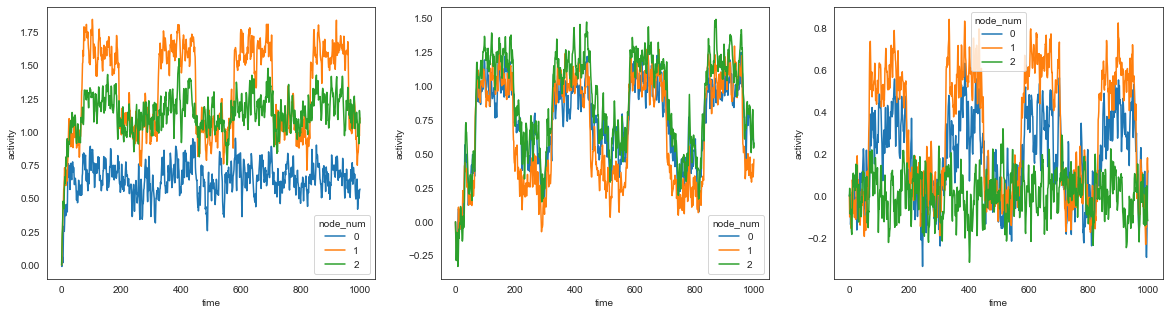

In [14]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3)

for i,j in enumerate([3,5,8]):
    task1_data_df = pd.DataFrame(task_data[j])
    task1_data_df['node_num'] = task1_data_df.index
    task1_data_df = task1_data_df.melt(id_vars = ['node_num'])
    task1_data_df['node_num'] = task1_data_df["node_num"].astype('category')
    task1_data_df = task1_data_df.rename(columns={"variable": "time", "value": "activity"})
    task1_data_df = task1_data_df.query('time < 1000')
    sns.lineplot(data=task1_data_df, x="time", y="activity", hue="node_num", ax= a[i])

Run task GLM on neural (not BOLD) level

In [15]:
task_betas = np.ndarray(num_sims, dtype=object)

for i in range(num_sims):
    task_betas[i] = run_glm(task_data[i], tasktiming)


## Using resting FC

In [18]:
actflow_preds = np.ndarray(num_sims, dtype=object)

for i in range(num_sims):
    actflow_preds[i] = actflow(task_betas[i], rest_pearson_fcs[i])

Plot predicted versus actual activations (scatterplot color by node)

Text(0, 0.5, 'Actflow predicted betas')

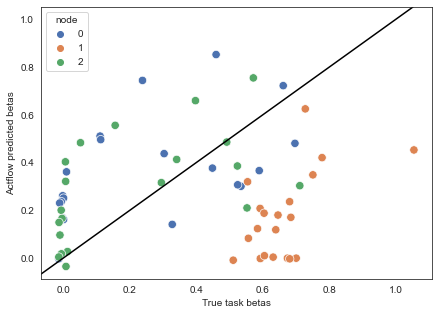

In [62]:
tmp = pd.DataFrame(np.vstack(task_betas))
tmp['network'] = list(range(num_sims))
tmp = pd.melt(tmp, id_vars = 'network', var_name = 'node', value_name = 'task_betas')

tmp2 = pd.DataFrame(np.vstack(actflow_preds))
tmp2['network'] = list(range(num_sims))
tmp2 = pd.melt(tmp2, id_vars = 'network', var_name = 'node', value_name = 'actflow_preds')

tmp = tmp.merge(tmp2, on=['network', 'node'])

plt.rcParams["figure.figsize"][0] = 7
plt.rcParams["figure.figsize"][1] = 5

sns.scatterplot(x='task_betas', y='actflow_preds', data = tmp, hue = 'node', palette='deep', s=70)
plt.axline([0, 0], [1, 1], color="black")
plt.xlabel("True task betas")
plt.ylabel("Actflow predicted betas")

Plot predicted versus actual activations as normalized heatmaps (a la Cole et al.)

Text(0.5, 1.0, 'Actflow predictions (raw)')

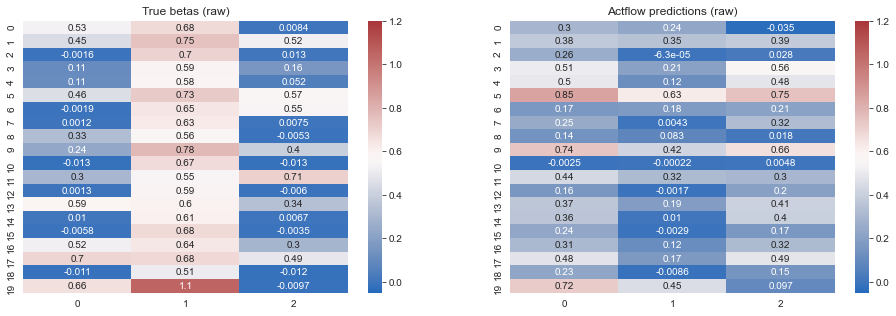

In [80]:
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 2)

sns.heatmap(pd.DataFrame(np.vstack(task_betas)), ax=a[0], vmin=-.05, vmax=1.2, cmap="vlag", annot=True)
a[0].set_title('True betas (raw)')
sns.heatmap(pd.DataFrame(np.vstack(actflow_preds)), ax=a[1], vmin=-.05, vmax=1.2, cmap="vlag", annot=True)
a[1].set_title('Actflow predictions (raw)')

Do things look better standardized (mean centered and unit variance)?

Text(0.5, 1.0, 'Actflow predictions (standardized)')

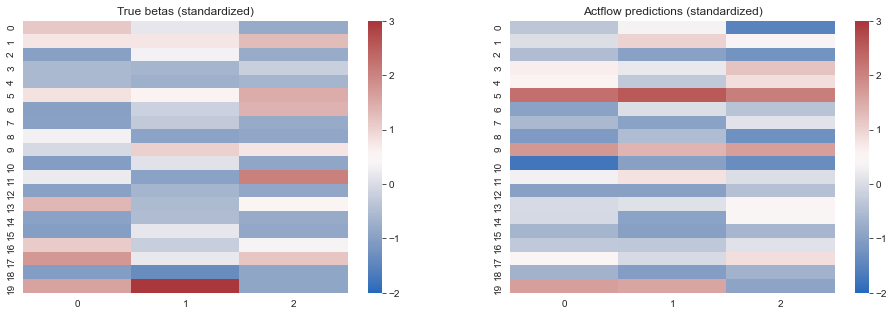

In [88]:
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 2)

sns.heatmap(pd.DataFrame(scale(np.vstack(task_betas))), ax=a[0], vmin=-2, vmax=3, cmap="vlag")
a[0].set_title('True betas (standardized)')
sns.heatmap(pd.DataFrame(scale(np.vstack(actflow_preds))), ax=a[1], vmin=-2, vmax=3, cmap="vlag")
a[1].set_title('Actflow predictions (standardized)')

<font color='red'>Is this what Cole et al. depict too? Or do they process the coefficients some other way?</font>

## Using Task FC

How does task functional connectivity differ from rest FC?

In [ ]:
task_pearson_fcs = np.ndarray(num_sims, dtype=object)
task_pearson_fcs_lb = np.ndarray(num_sims, dtype=object)
task_pearson_fcs_ub = np.ndarray(num_sims, dtype=object)
task_pearson_fcs_rmse = np.ndarray(num_sims, dtype=object)
task_mreg_fcs = np.ndarray(num_sims, dtype=object)
task_mreg_fcs_lb = np.ndarray(num_sims, dtype=object)
task_mreg_fcs_ub = np.ndarray(num_sims, dtype=object)
task_mreg_fcs_rmse = np.ndarray(num_sims, dtype=object)


for i, cur_data in enumerate(task_data):
    task_pearson_fcs[i], task_pearson_fcs_lb[i], task_pearson_fcs_ub[i], task_pearson_fcs_rmse[i] = get_pearson_fc_wci(cur_data, networks[i])
    task_mreg_fcs[i], task_mreg_fcs_lb[i], task_mreg_fcs_ub[i], task_mreg_fcs_rmse[i] = get_multreg_fc_wci(cur_data, networks[i])

Does task FC do a better job in actflow?

## Sanity check

does the true connectivity matrix do better in actflow?

## Using directed connectivity 

Can we improve on activity flow mapping with directed connectivity estimates from resting state?